In [1]:
import sagemaker
import uuid

sagemaker_session = sagemaker.Session()
print('sagemaker version:' + sagemaker.__version__)

role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/emlo-s9-pt-cifar100_feb5-v1'

checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoint-{}'.format(bucket, checkpoint_suffix)
print(f'Current checkpointing path : {checkpoint_s3_path}')
print(f'S3 bucket: {bucket:}')

sagemaker version:2.74.0
Current checkpointing path : s3://sagemaker-us-east-1-751197368820/checkpoint-33a2357e
S3 bucket: sagemaker-us-east-1-751197368820


In [2]:
import os
import subprocess 

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    # Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print('instance_type:', instance_type)

instance_type: local


In [3]:
!pip install pytorch-lightning --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.2.0 requires pyqt5<5.13, which is not installed.
spyder 4.2.0 requires pyqtwebengine<5.13, which is not installed.
s3fs 2021.4.0 requires fsspec==2021.04.0, but you have fsspec 2022.1.0 which is incompatible.


In [4]:
import pytorch_lightning as pl
class CIFAR100DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './data'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
        ])

        self.transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
        ])
        
        self.dims = (3, 32, 32)
        self.num_classes = 10

    def prepare_data(self):
        # download 
        torchvision.datasets.CIFAR100(self.data_dir, train=True, download=True)
        torchvision.datasets.CIFAR100(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        cifar_full = torchvision.datasets.CIFAR100(self.data_dir, train=True, transform=self.transform_train)
        self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        self.cifar_test = torchvision.datasets.CIFAR100(self.data_dir, train=False, transform=self.transform_test)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=4)

In [5]:
import numpy as np
import torchvision, torch
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR100
from torchvision import transforms

dm = CIFAR100DataModule(batch_size=32)
dm.prepare_data()
dm.setup()
trainloader = dm.train_dataloader()
testloader = dm.test_dataloader()

# function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
#function to read files present in the Python version of the dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict

metaData = unpickle('./data/cifar-100-python/meta')
label_names = metaData['fine_label_names']
print(len(label_names))

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


Files already downloaded and verified
Files already downloaded and verified
100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49 mountain
33 forest
72 seal
51 mushroom


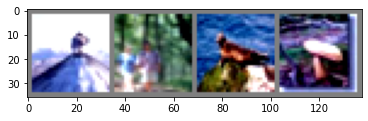

In [6]:
# get some random test images to see if testloader works fine & images are getting displayed correctly
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
labels_list = labels.tolist()
for i in range(len(labels_list)):
    print(labels_list[i], label_names[labels_list[i]] )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Showing label names of first 8 train images
30 dolphin
59 pine_tree
24 cockroach
17 castle
4 beaver
66 raccoon
36 hamster
9 bottle


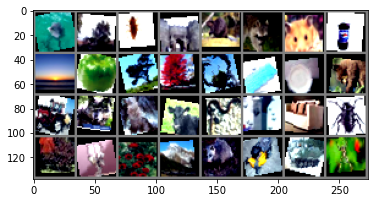

In [7]:
# get some random train images to see if trainloader works fine & images are getting displayed correctly
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
labels_list = labels.tolist()
print('Showing label names of first 8 train images')
for i in range(8):
    print(labels_list[i], label_names[labels_list[i]] )


In [8]:
inputs = sagemaker_session.upload_data(path = "data", bucket = bucket, key_prefix="data/cifar100")

In [9]:
from sagemaker.pytorch import PyTorch

In [10]:
use_spot_instances = True
max_run = 1200
max_wait = 1210 if use_spot_instances else None

In [11]:
# The local path where the model will save its checkpoints in the training container. This needs to be given for ckpt to work
checkpoint_local_path="/opt/ml/checkpoints"
wandb_api_key = "e653df8526c77d083379de033d13342620583fdf"

hyperparameters = {'batch_size': 32}

cifar100_estimator = PyTorch(
    entry_point = "cifar100_pl_v12.py",
    role=role,
    framework_version="1.7.1",
    py_version="py3",
    source_dir='./source_dir',
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type="ml.p3.8xlarge",
    base_job_name = 'cifar100-pytorch-Feb20-v1-2022-spot',
    checkpoint_s3_uri = checkpoint_s3_path,
    checkpoint_local_path=checkpoint_local_path,
    debugger_hook_config = False,
    use_spot_instances = use_spot_instances,
    max_run = max_run,
    max_wait = max_wait,
    environment={"WANDB_API_KEY":wandb_api_key})

In [ ]:
cifar100_estimator.fit(inputs)

2022-02-26 11:48:55 Starting - Starting the training job...
2022-02-26 11:49:18 Starting - Launching requested ML instancesProfilerReport-1645876135: InProgress
.........
2022-02-26 11:50:39 Starting - Insufficient capacity error from EC2 while launching instances, retrying!.................................................................................................................

In [13]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
from sagemaker.pytorch import PyTorchModel
predictor = cifar100_estimator.deploy(initial_instance_count+1,instance_type = "ml.c4.8xlarge")